In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

# Modeling Secondary Eclipse Spectroscopy

In [3]:
import coronagraph as cg
print(cg.__version__)

0.0.3


## Earth in Emission

Let's start out by loading a model spectrum of the Earth:

In [4]:
lam, tdepth, fplan, fstar = cg.get_earth_trans_spectrum()

Now we'll define the telescope/instrument parameters for our simulation:

In [5]:
telescope = cg.Telescope(Tput = 0.5,      # Throughput
                         D = 15.,         # Diameter [m]
                         R = 70,          # Resolving power (lam / dlam)
                         lammin  = 5.0,   # Minimum Wavelength [um]
                         lammax  = 20.0,  # Maximum Wavelength [um]
                         Tsys = 0.0,      # Telescope mirror temperature [K]
                        )  

as well as the planet and star:

In [6]:
planet = cg.Planet(a = 1.0,   # Semi-major axis [AU]
                   d = 10.0,  # Distance [pc]
                   Rp = 1.0   # Planet Radius [Earth Radii]
                  )

star = cg.Star(Rs = 1.0,      # Stellar Radius [Solar Radii]
               Teff = 5700.   # Stellar Effective Temperature [K]
              )

Let's specify the transit/eclipse duration `tdur` for the planet (Earth is this case), the number of eclipses to observe `ntran`, and the amount of observing out-of-eclipse (in units of eclipse durations) for each secondary eclipse observation `nout`. 

In [7]:
tdur = 8.0 * 60 * 60
ntran = 1e3
nout = 2.0

Now, we can instantiate an `EclipseNoise` object for our simulation which contains all of the information needed to perform the noise calculation:

In [8]:
en = cg.EclipseNoise(tdur = tdur,
                     telescope = telescope,
                     planet = planet,
                     star = star,
                     ntran = ntran,
                     nout = nout)

At this point we are ready to run the simulation and can simply call the `run_count_rates` method:

In [9]:
en.run_count_rates(lam, fplan, fstar)

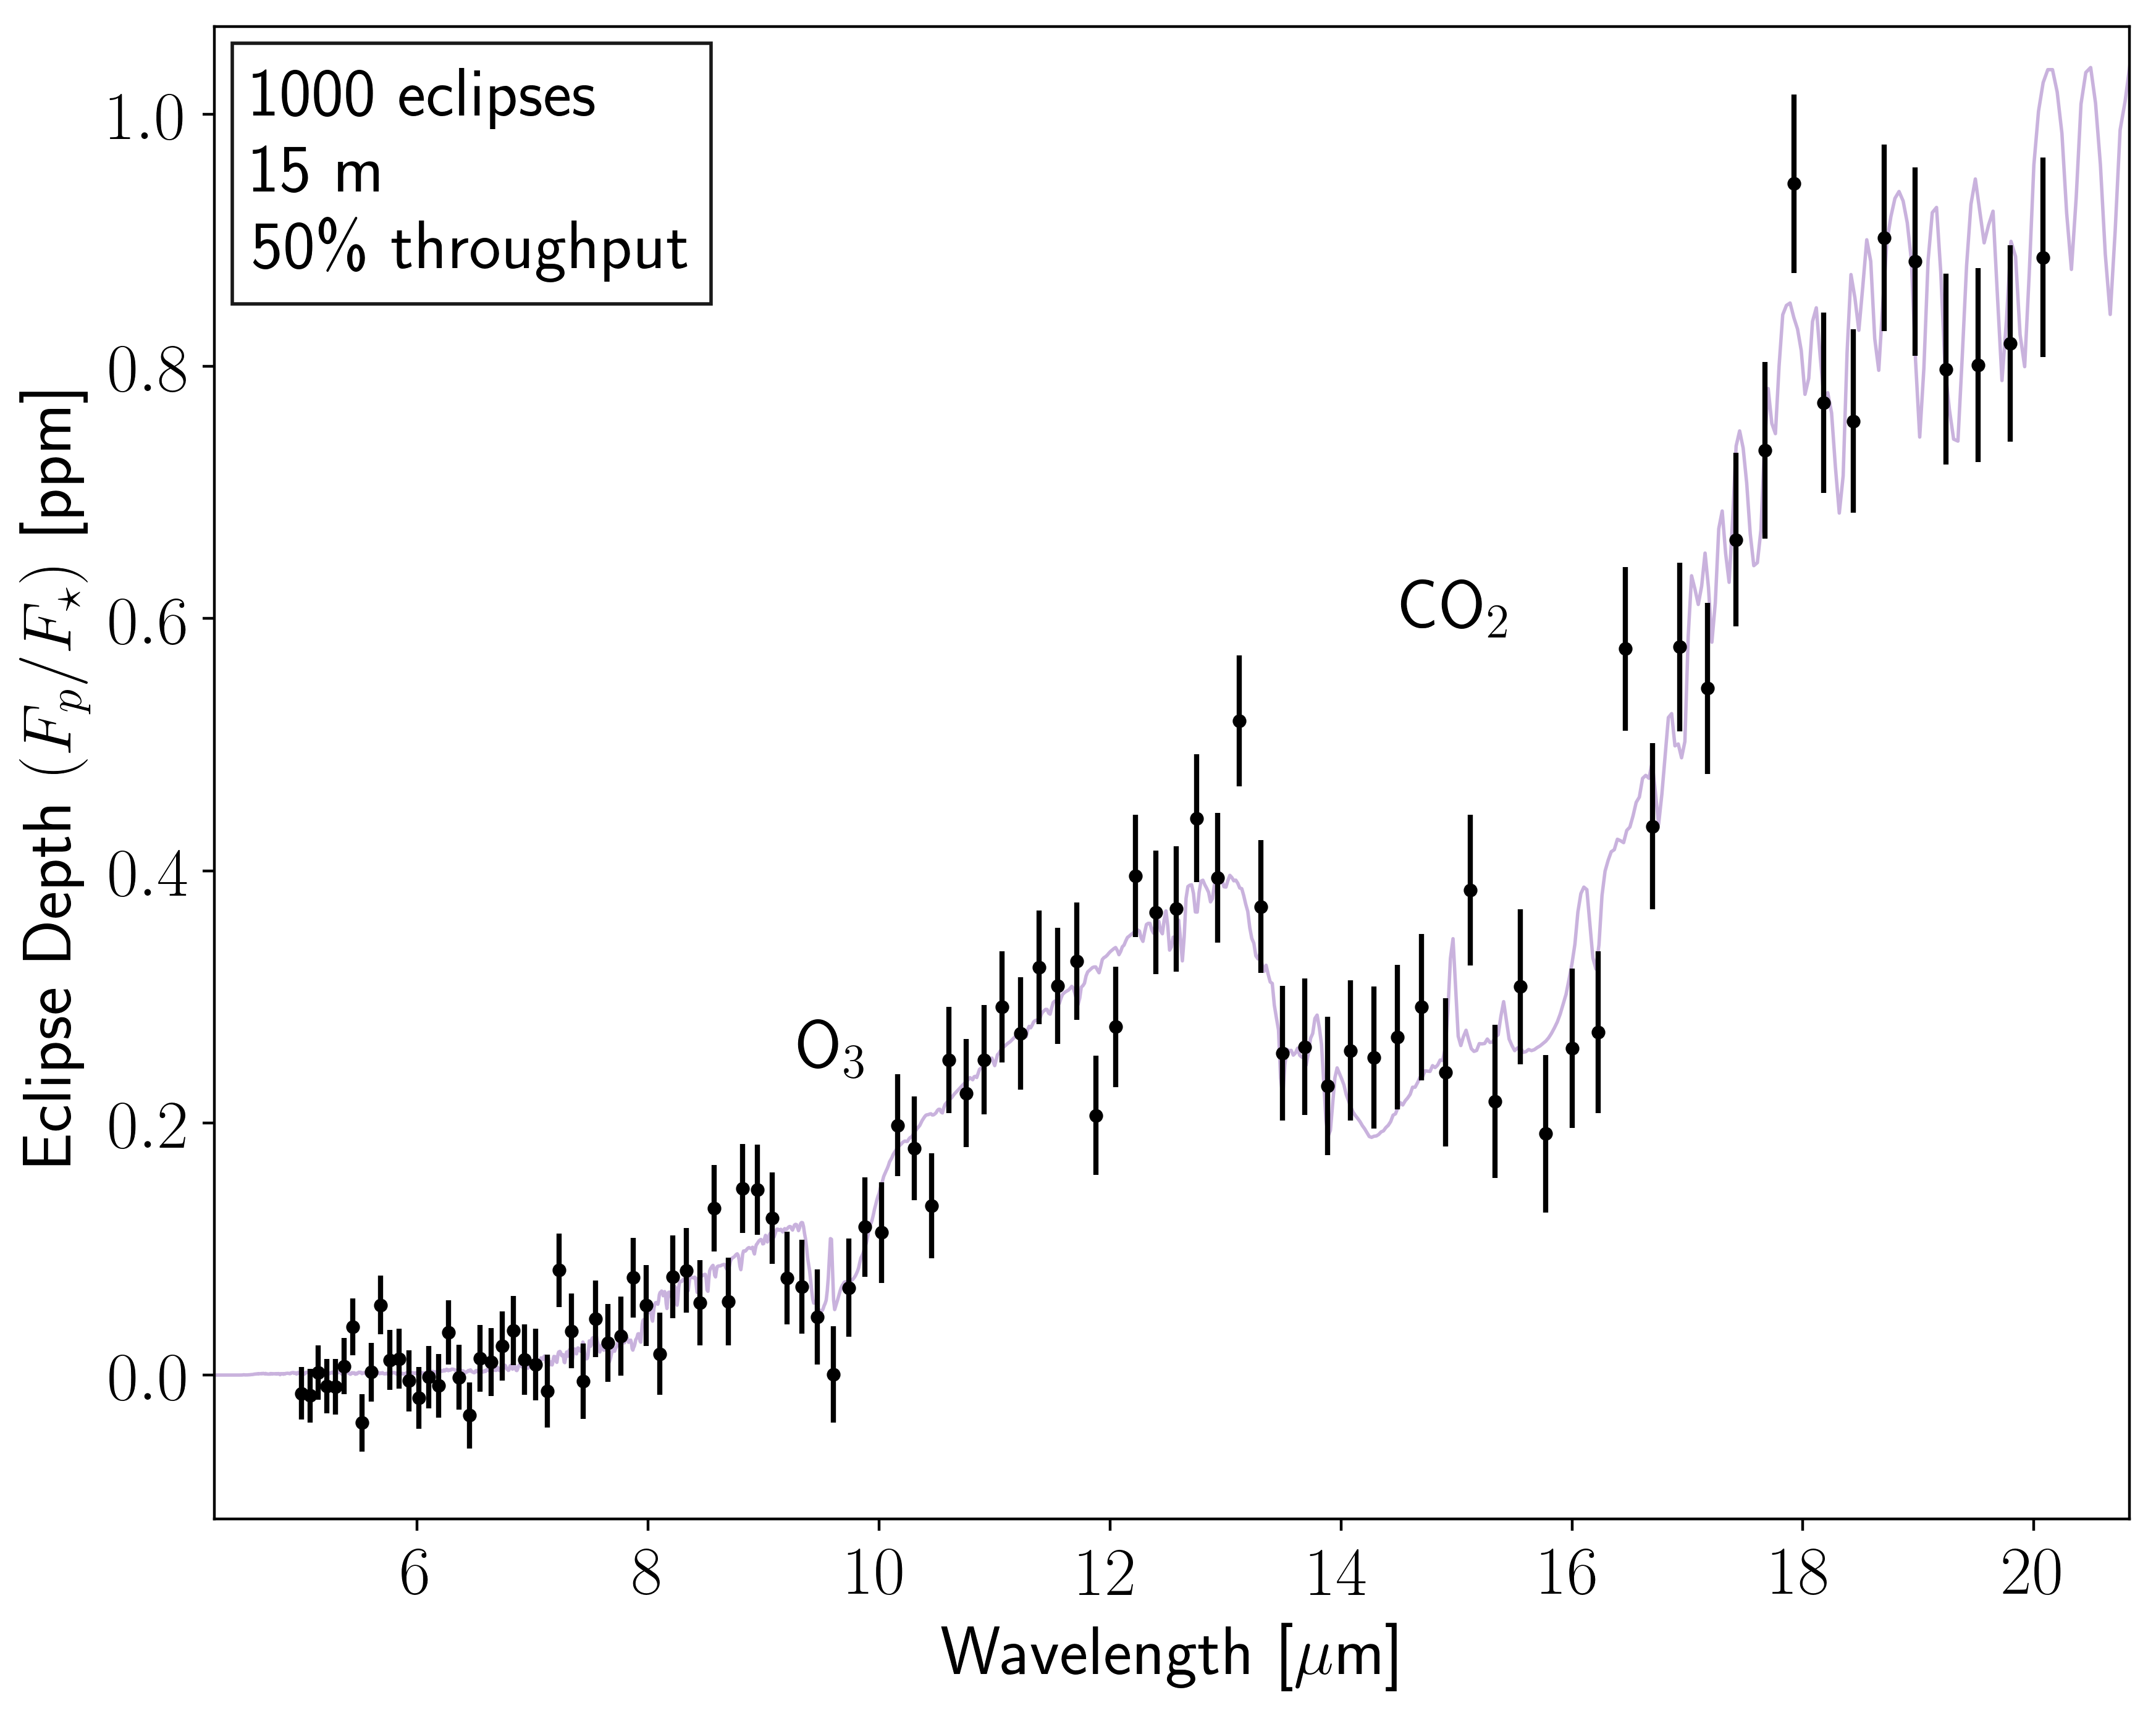

In [10]:
fig, ax = en.plot_spectrum(SNR_threshold=0.0, Nsig=None)
ax.text(15.0, 0.6, r"CO$_2$", va = "center", ha = "center");
ax.text(9.6, 0.25, r"O$_3$", va = "center", ha = "center");

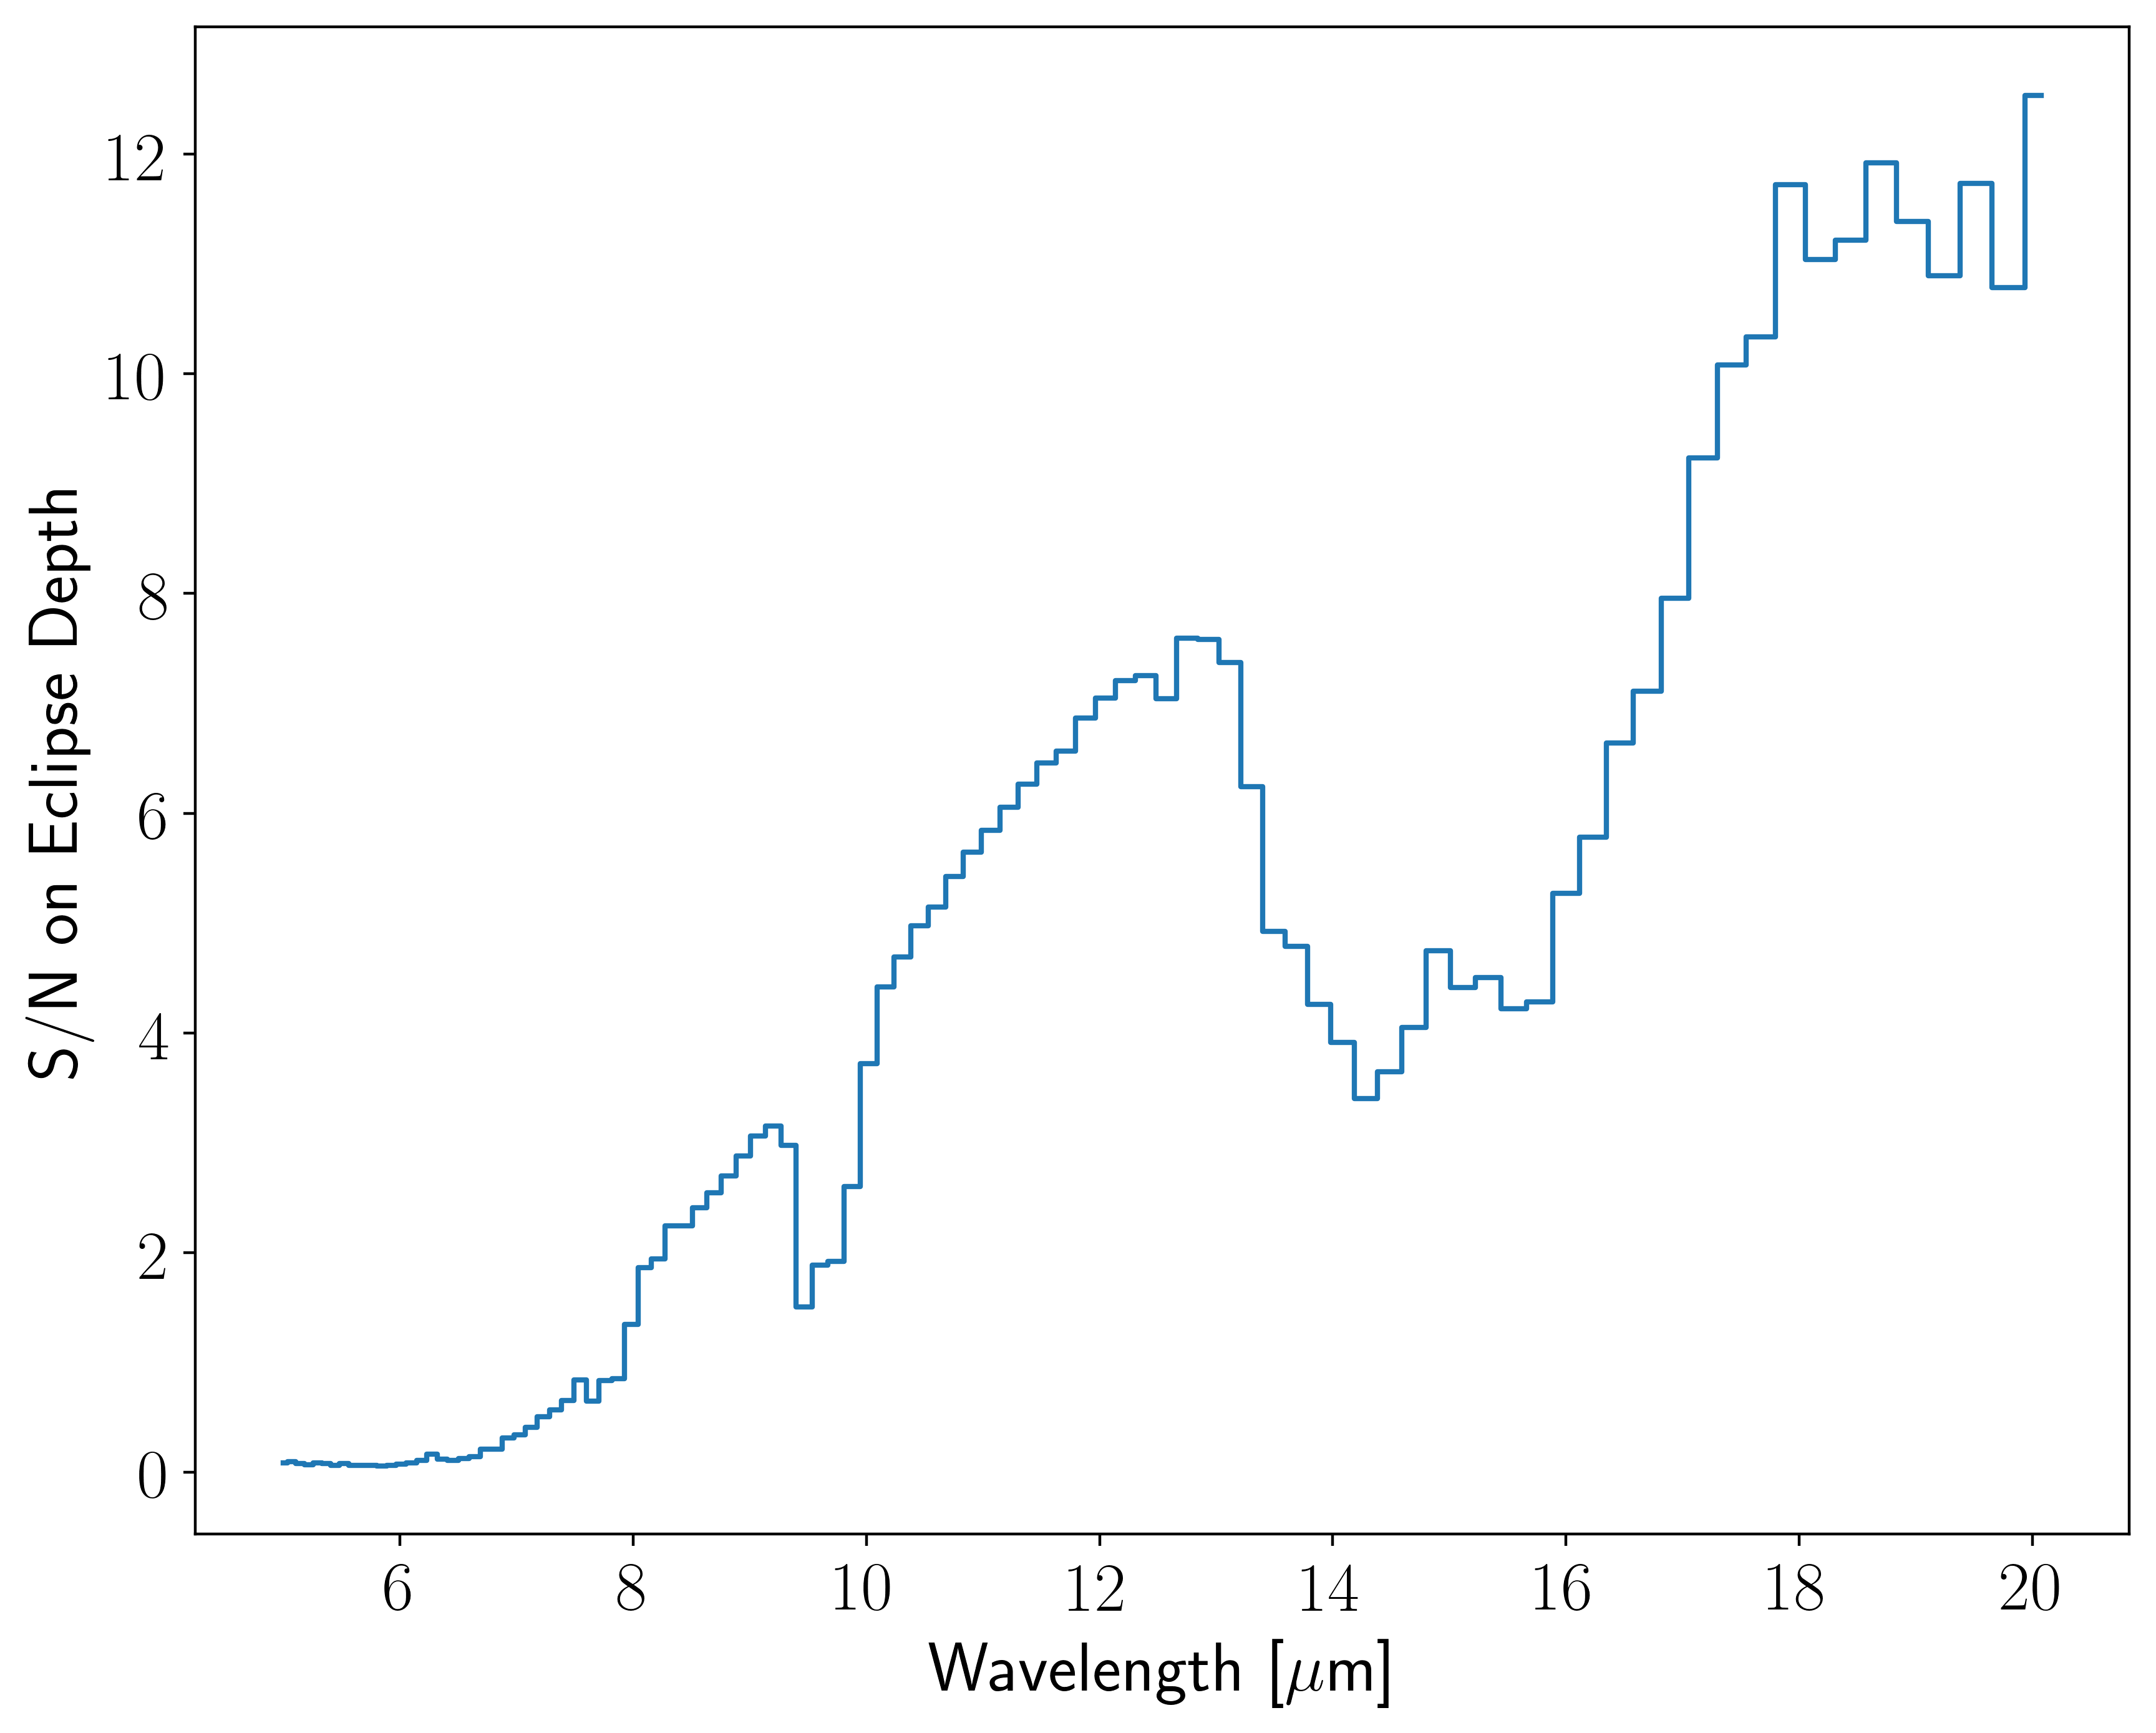

In [11]:
# Plot the SNR
fig, ax = en.plot_SNRn()

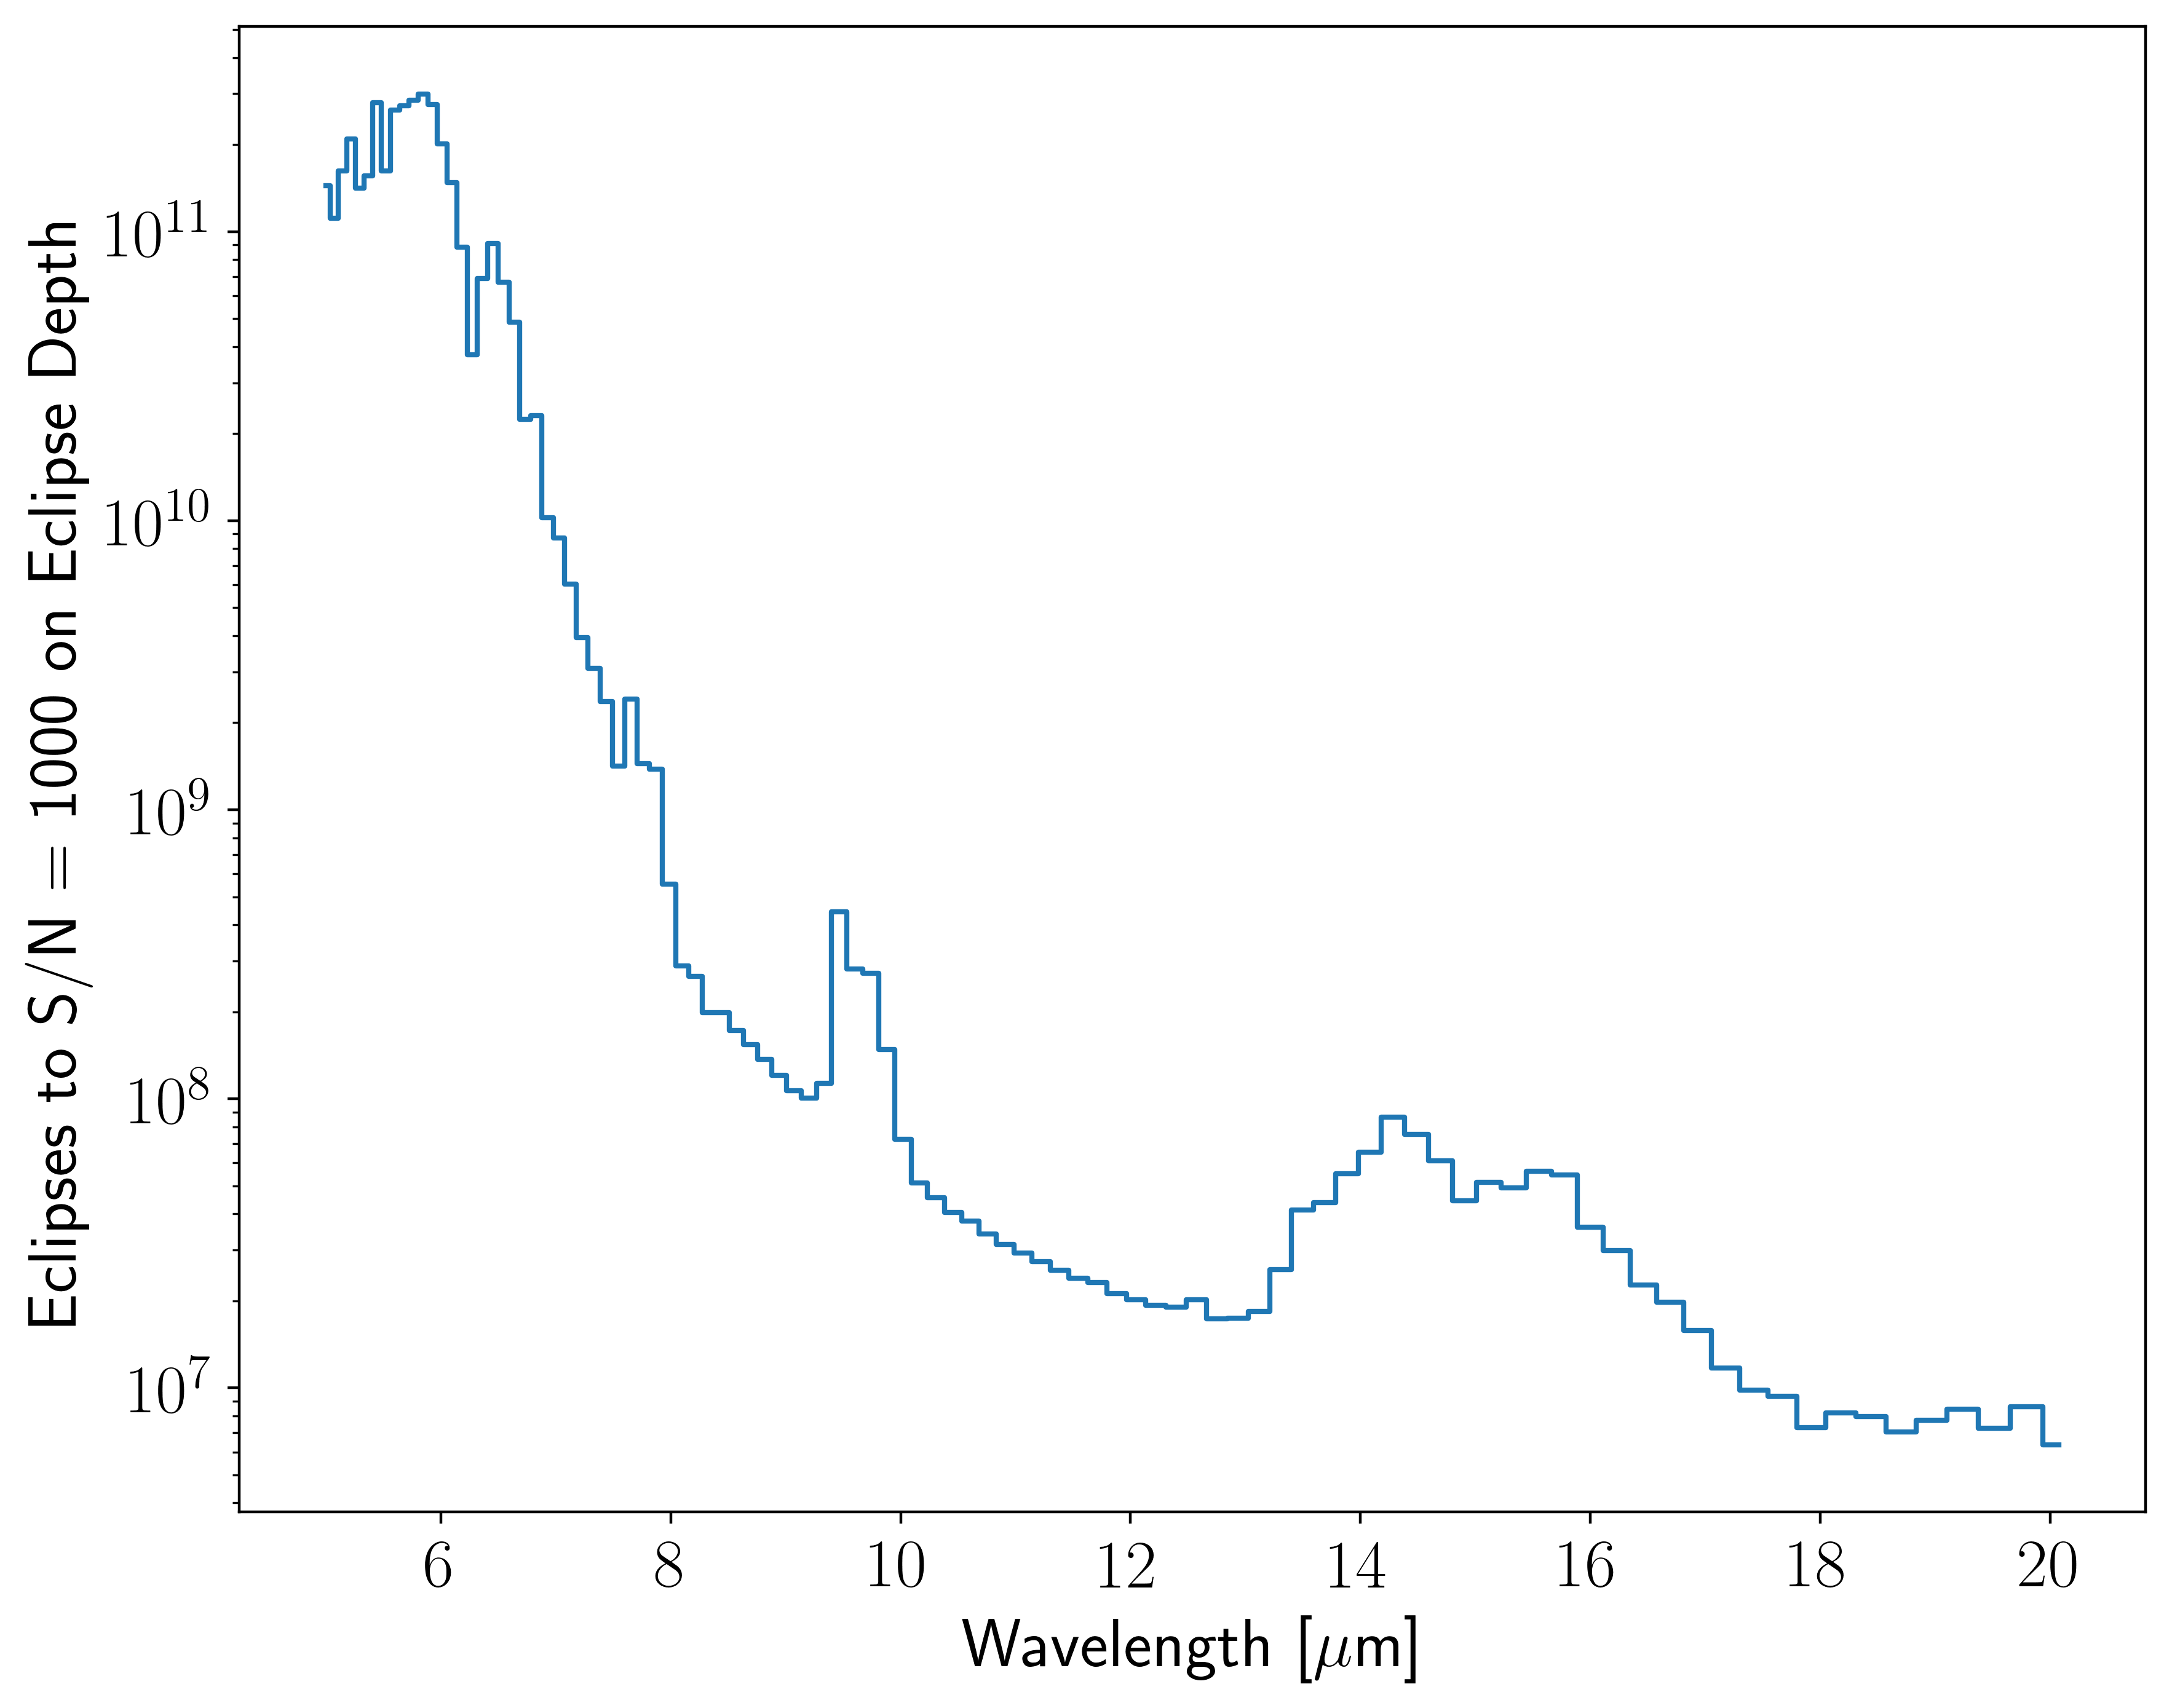

In [12]:
# Plot the number of transits to given SNR
fig, ax = en.plot_ntran_to_wantsnr()

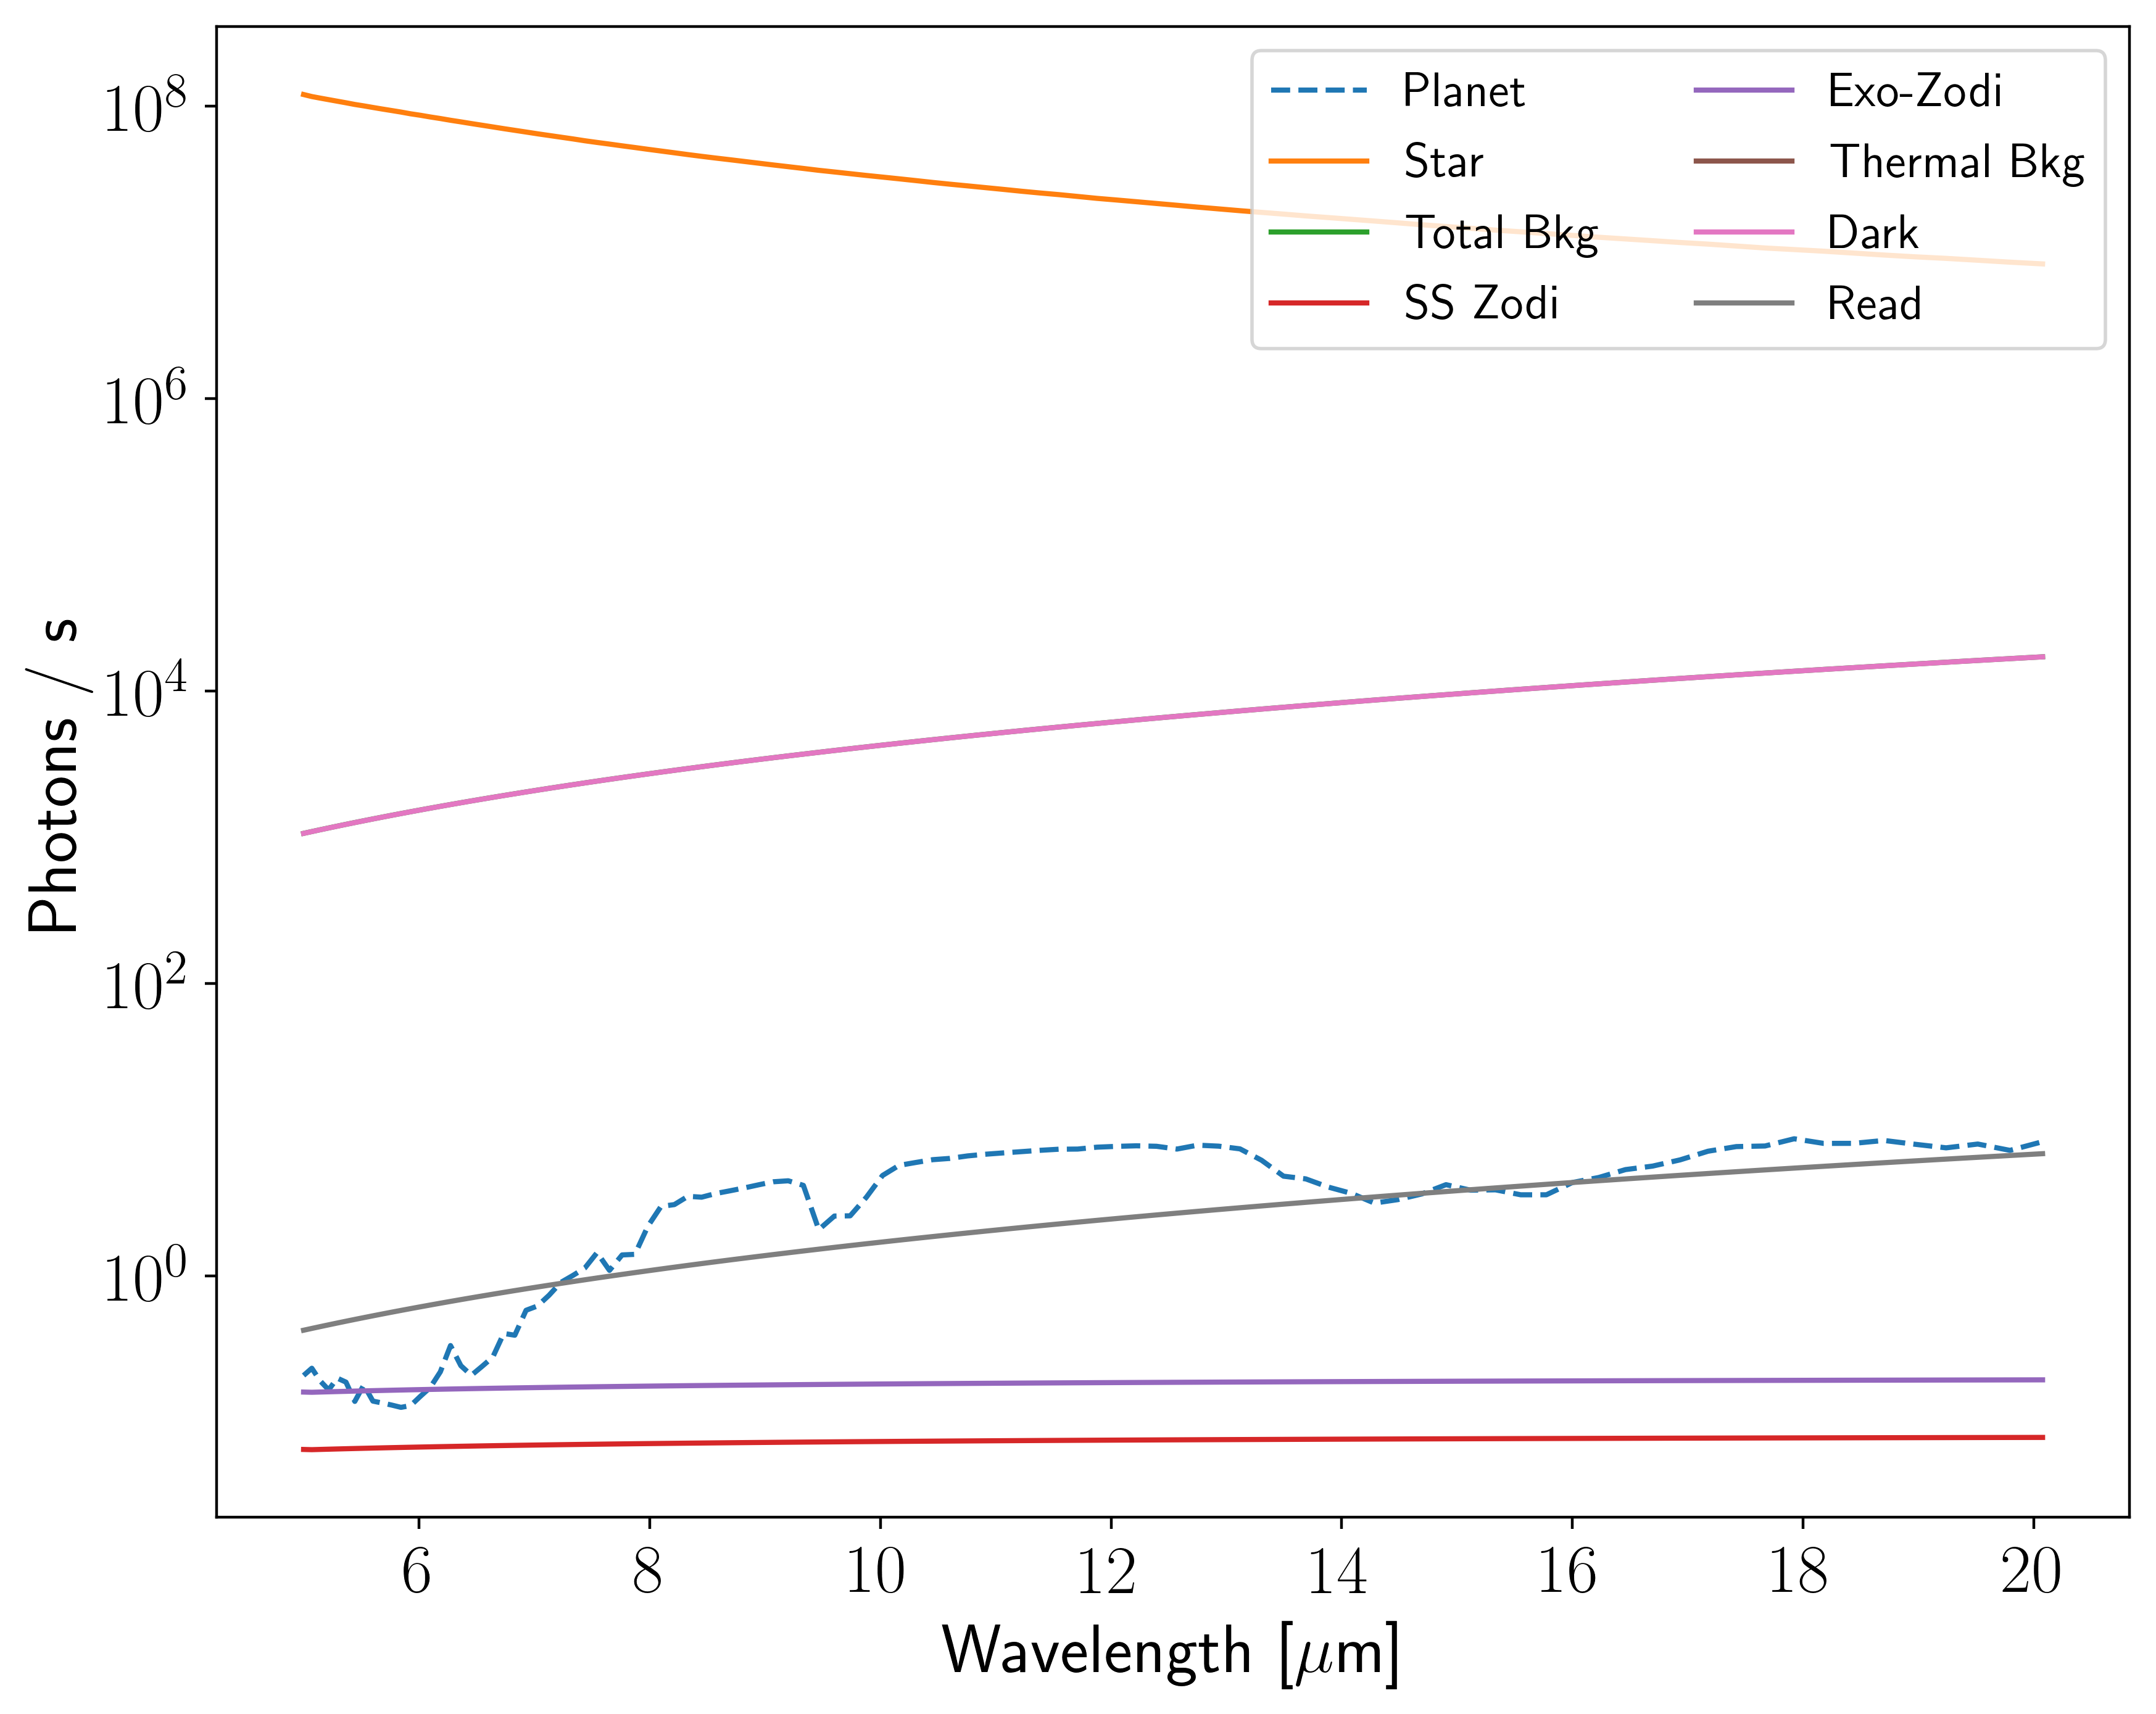

In [13]:
# Plot the count rates
fig, ax = en.plot_count_rates()

## Simulating a *featureless* spectrum

In [14]:
planet = cg.Planet(a = 1.0,   # Semi-major axis [AU]
                   d = 10.0,  # Distance [pc]
                   Rp = 1.0   # Planet Radius [Earth Radii]
                  )

star = cg.Star(Rs = 1.0,      # Stellar Radius [Solar Radii]
               Teff = 5700.   # Stellar Effective Temperature [K]
              )

In [15]:
planet.Tplan = 288

In [16]:
enf = cg.EclipseNoise(tdur = tdur,
                      telescope = telescope,
                      planet = planet,
                      star = star,
                      ntran = ntran,
                      nout = nout)

In [17]:
enf.run_count_rates(lam)

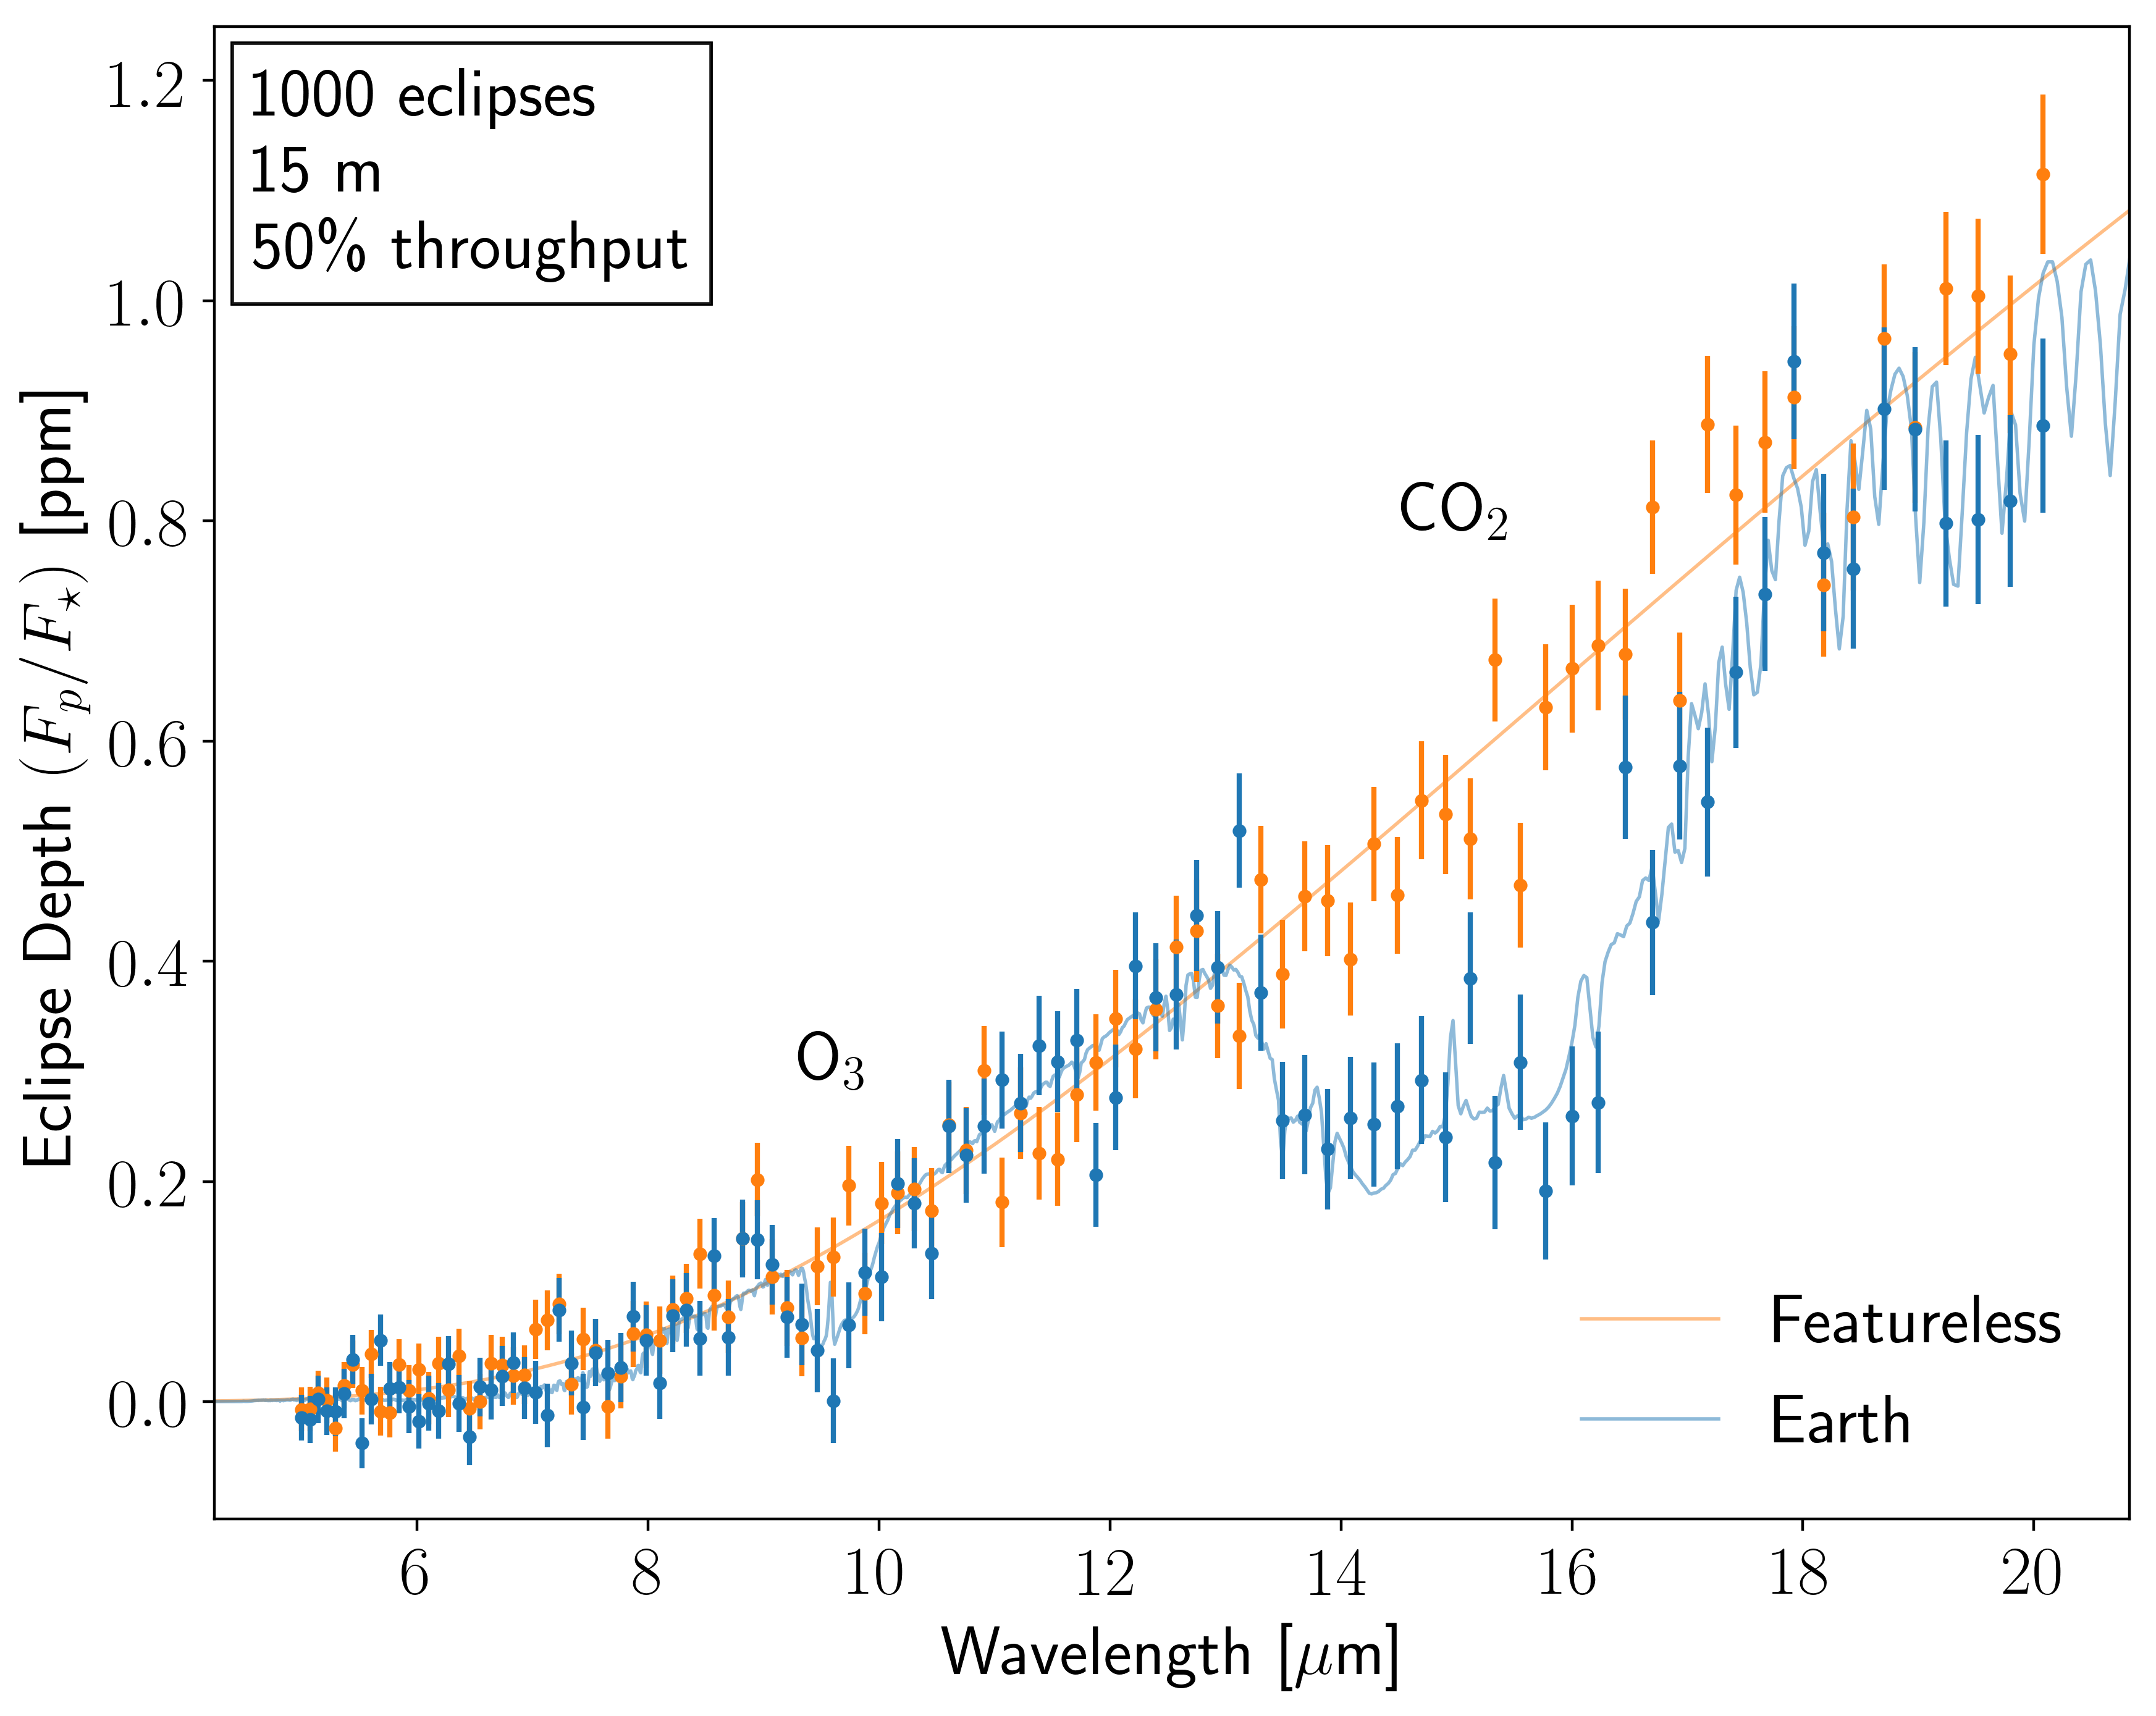

In [18]:
# Plot Spectrum
fig, ax = enf.plot_spectrum(SNR_threshold=0.0, Nsig=None, 
                            err_kws={'fmt': '.', 'c': 'C1', 'alpha': 1}, 
                            plot_kws={'lw': 1.0, 'c': 'C1', 'alpha': 0.5, 'label' : 'Featureless'})

# Add Earth's emission spectrum to the axis
en.plot_spectrum(SNR_threshold=0.0, Nsig=None, ax0=ax, 
                 err_kws={'fmt': '.', 'c': 'C0', 'alpha': 1}, 
                 plot_kws={'lw': 1.0, 'c': 'C0', 'alpha': 0.5, 'label' : 'Earth'})

# Add legend
leg = ax.legend(loc = 4)
leg.get_frame().set_alpha(0.0)

# Annotate molecules
ax.text(15.0, 0.8, r"CO$_2$", va = "center", ha = "center");
ax.text(9.6, 0.3, r"O$_3$", va = "center", ha = "center");

## What about M-dwarfs?

In [19]:
star.Teff = 2510
star.Rs = 0.117

In [20]:
enm = cg.EclipseNoise(tdur = 3432.0,
                      telescope = telescope,
                      planet = planet,
                      star = star,
                      ntran = 25.0,
                      nout = nout)

In [21]:
enm.run_count_rates(lam, fplan)

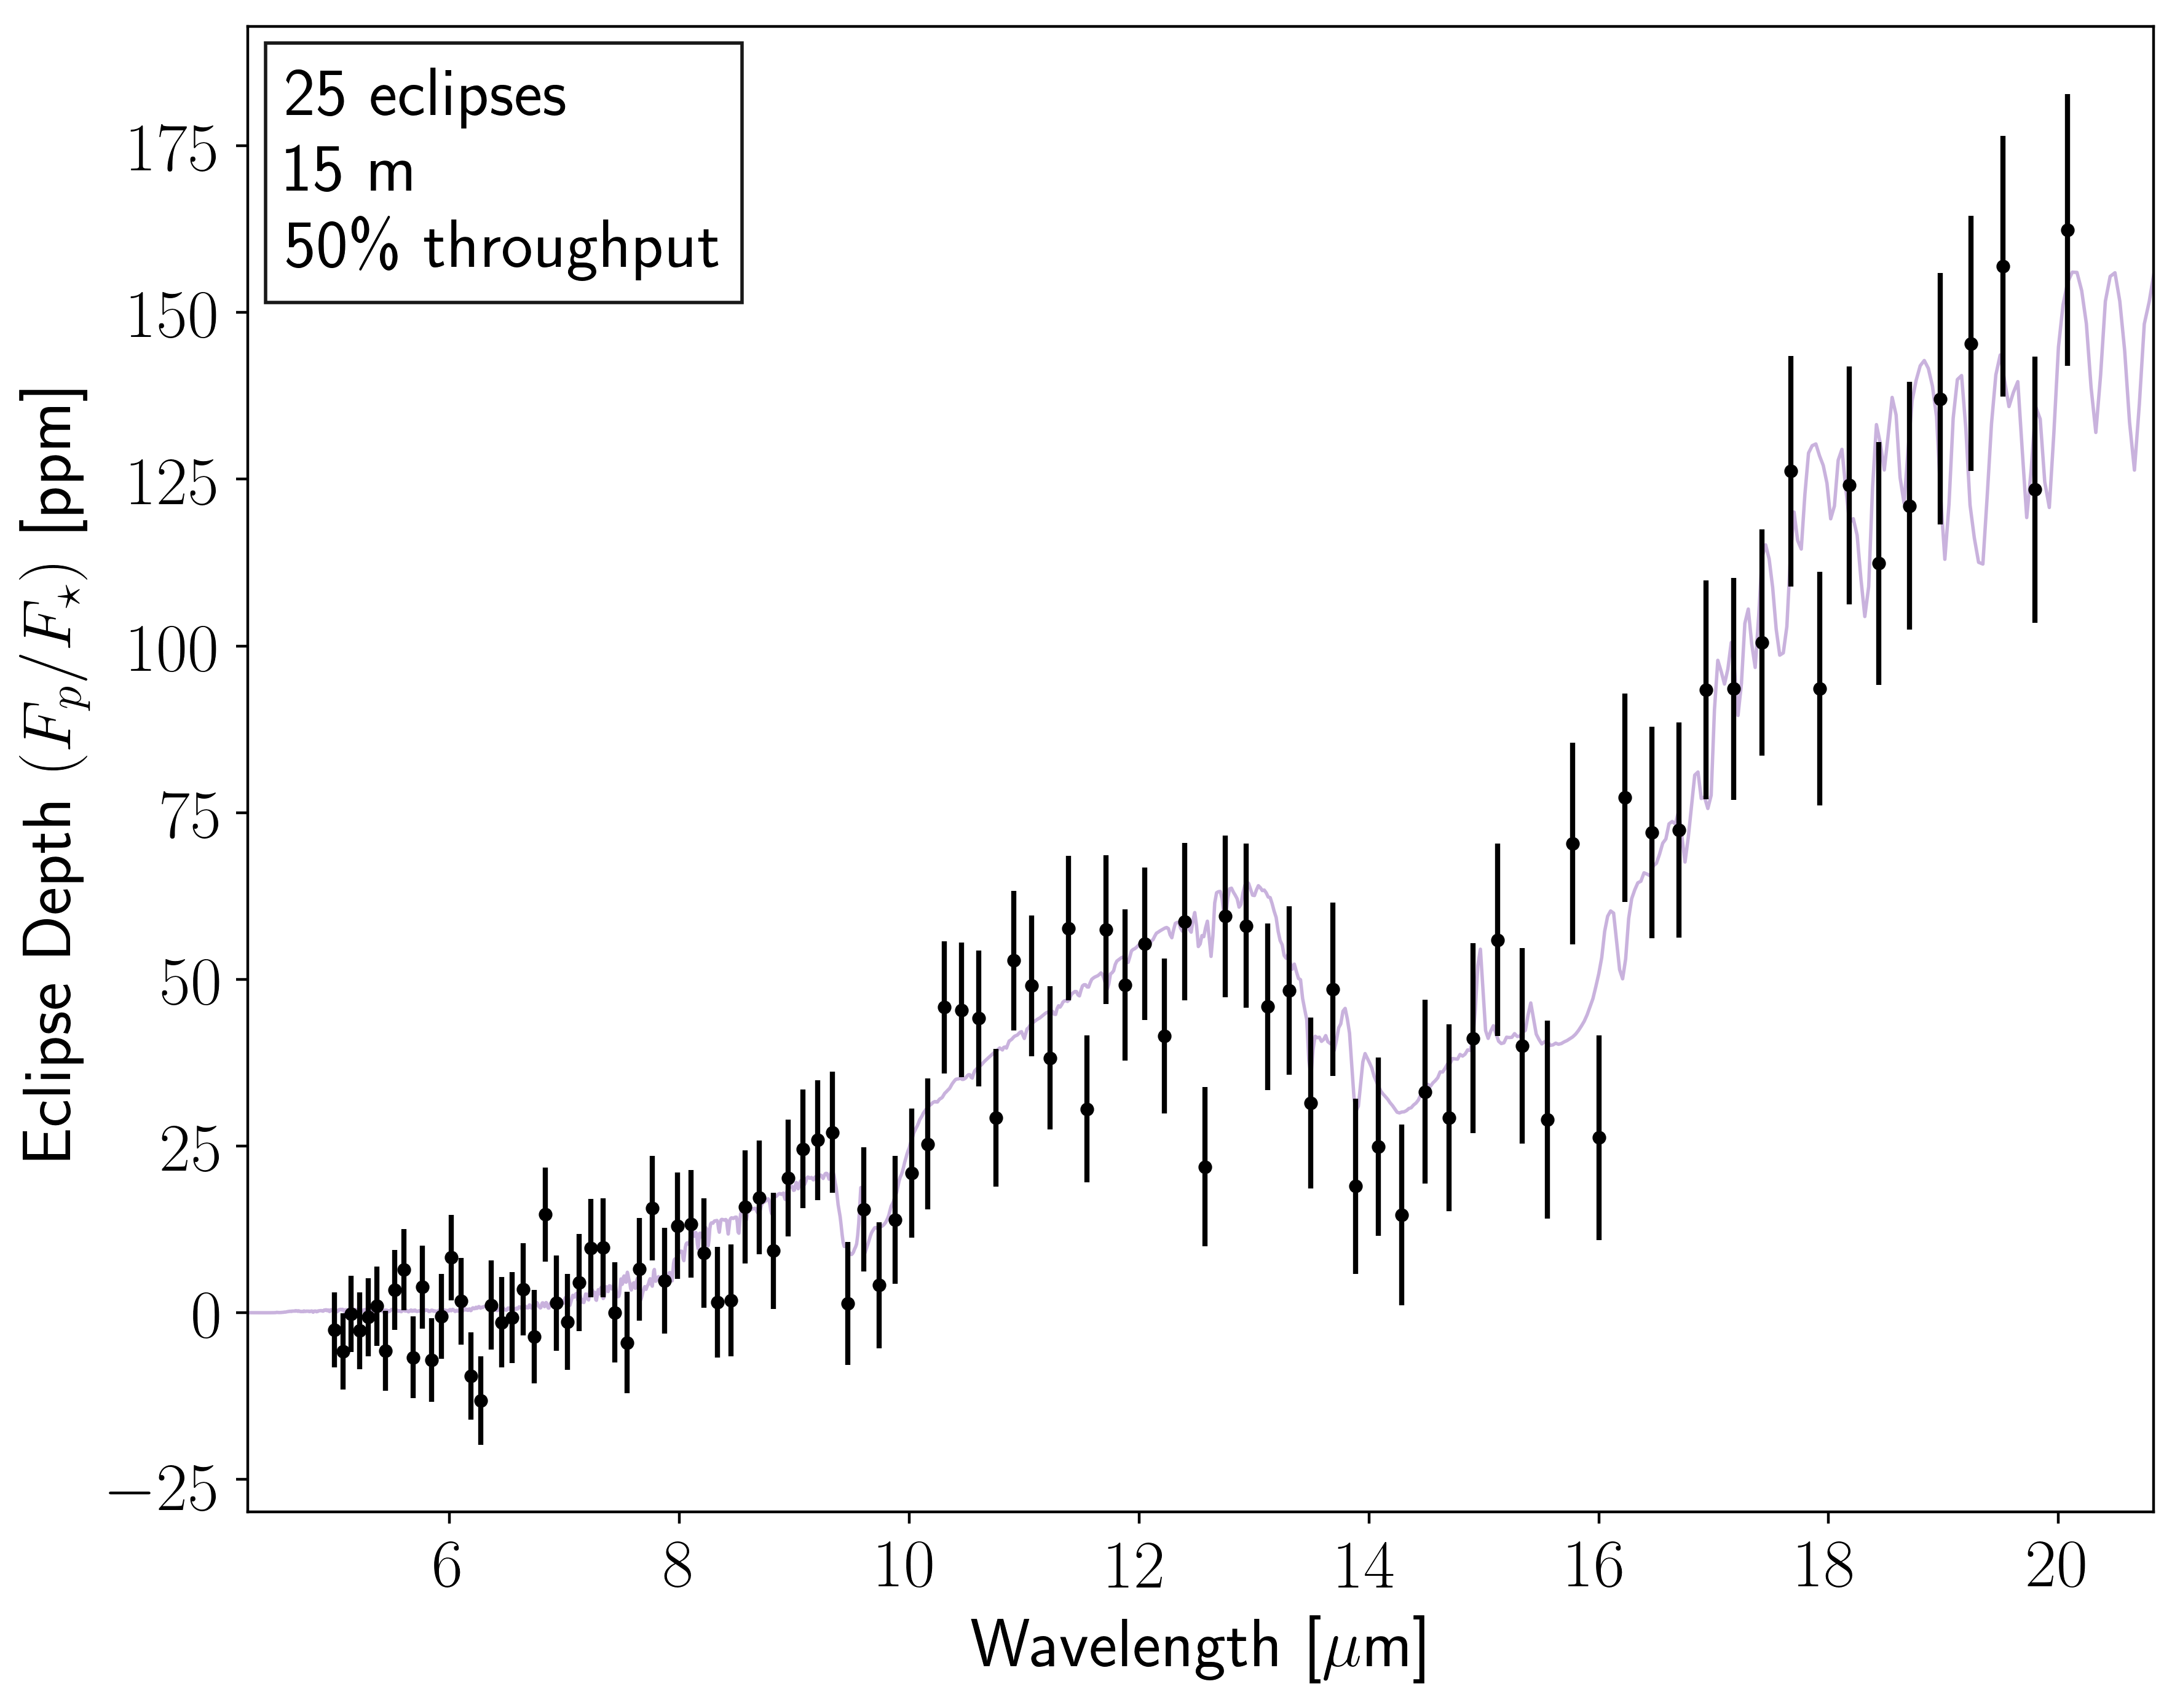

In [22]:
fig, ax = enm.plot_spectrum(SNR_threshold=0.0, Nsig=None)

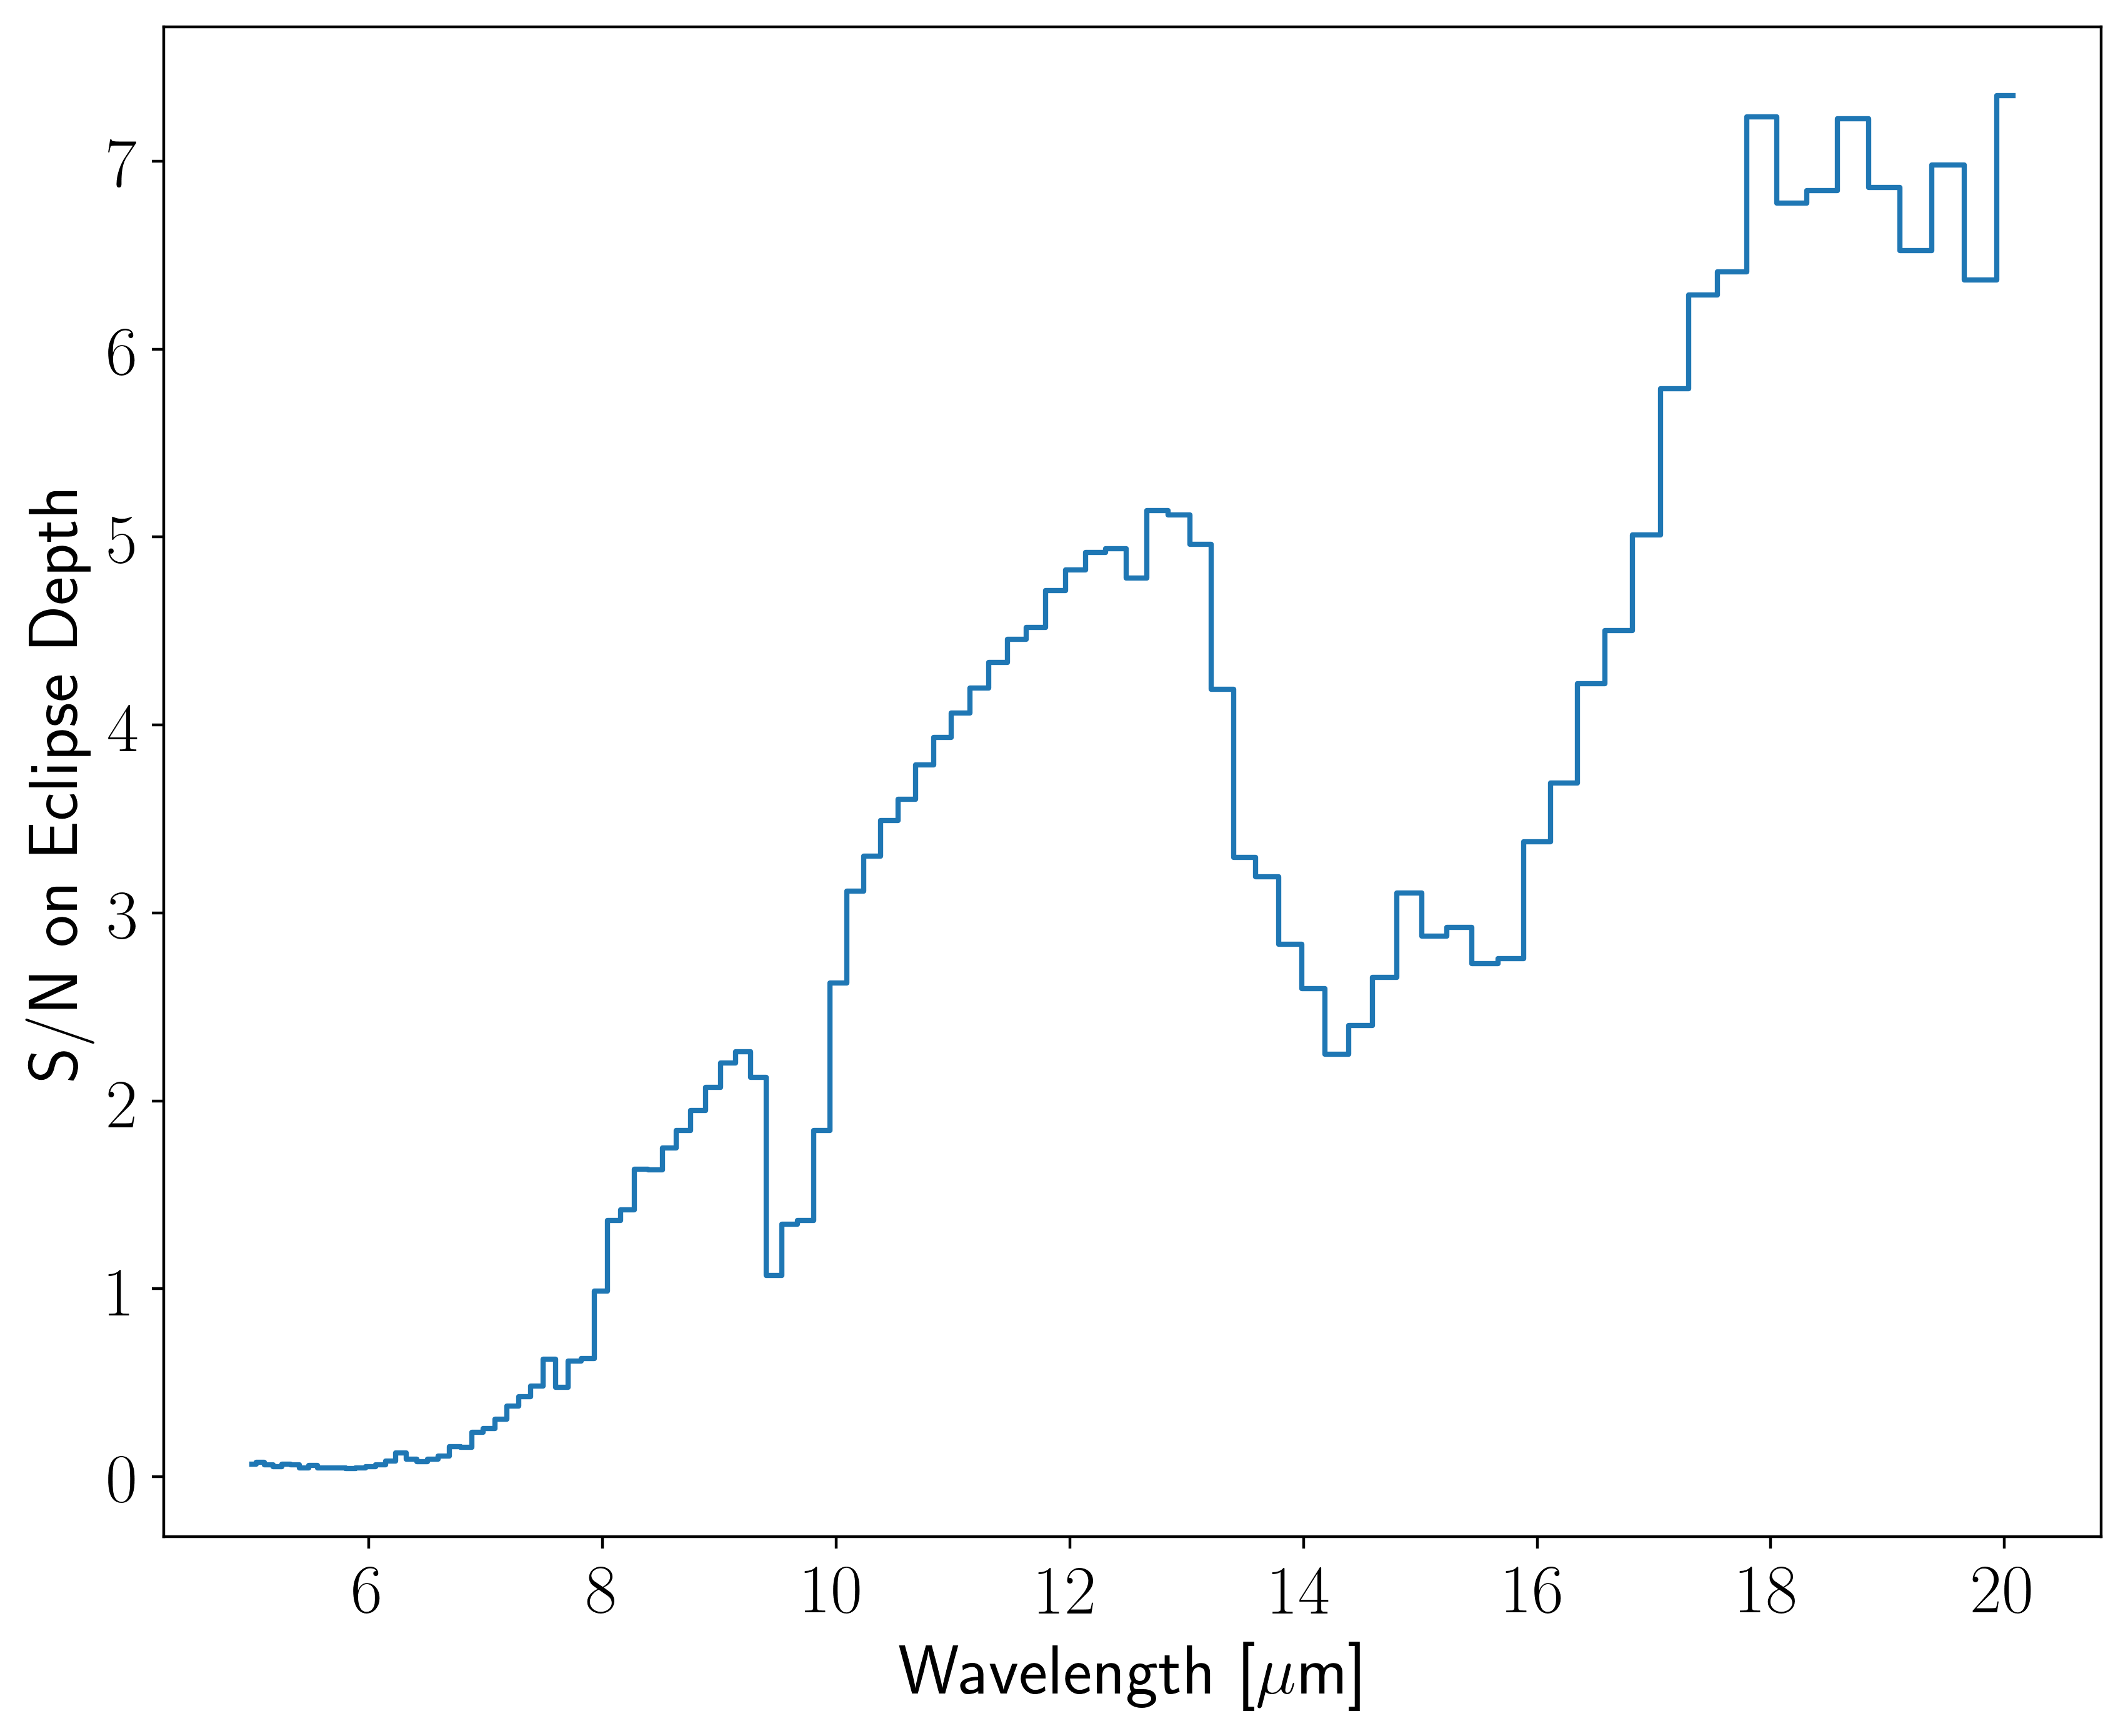

In [23]:
fig, ax = enm.plot_SNRn()

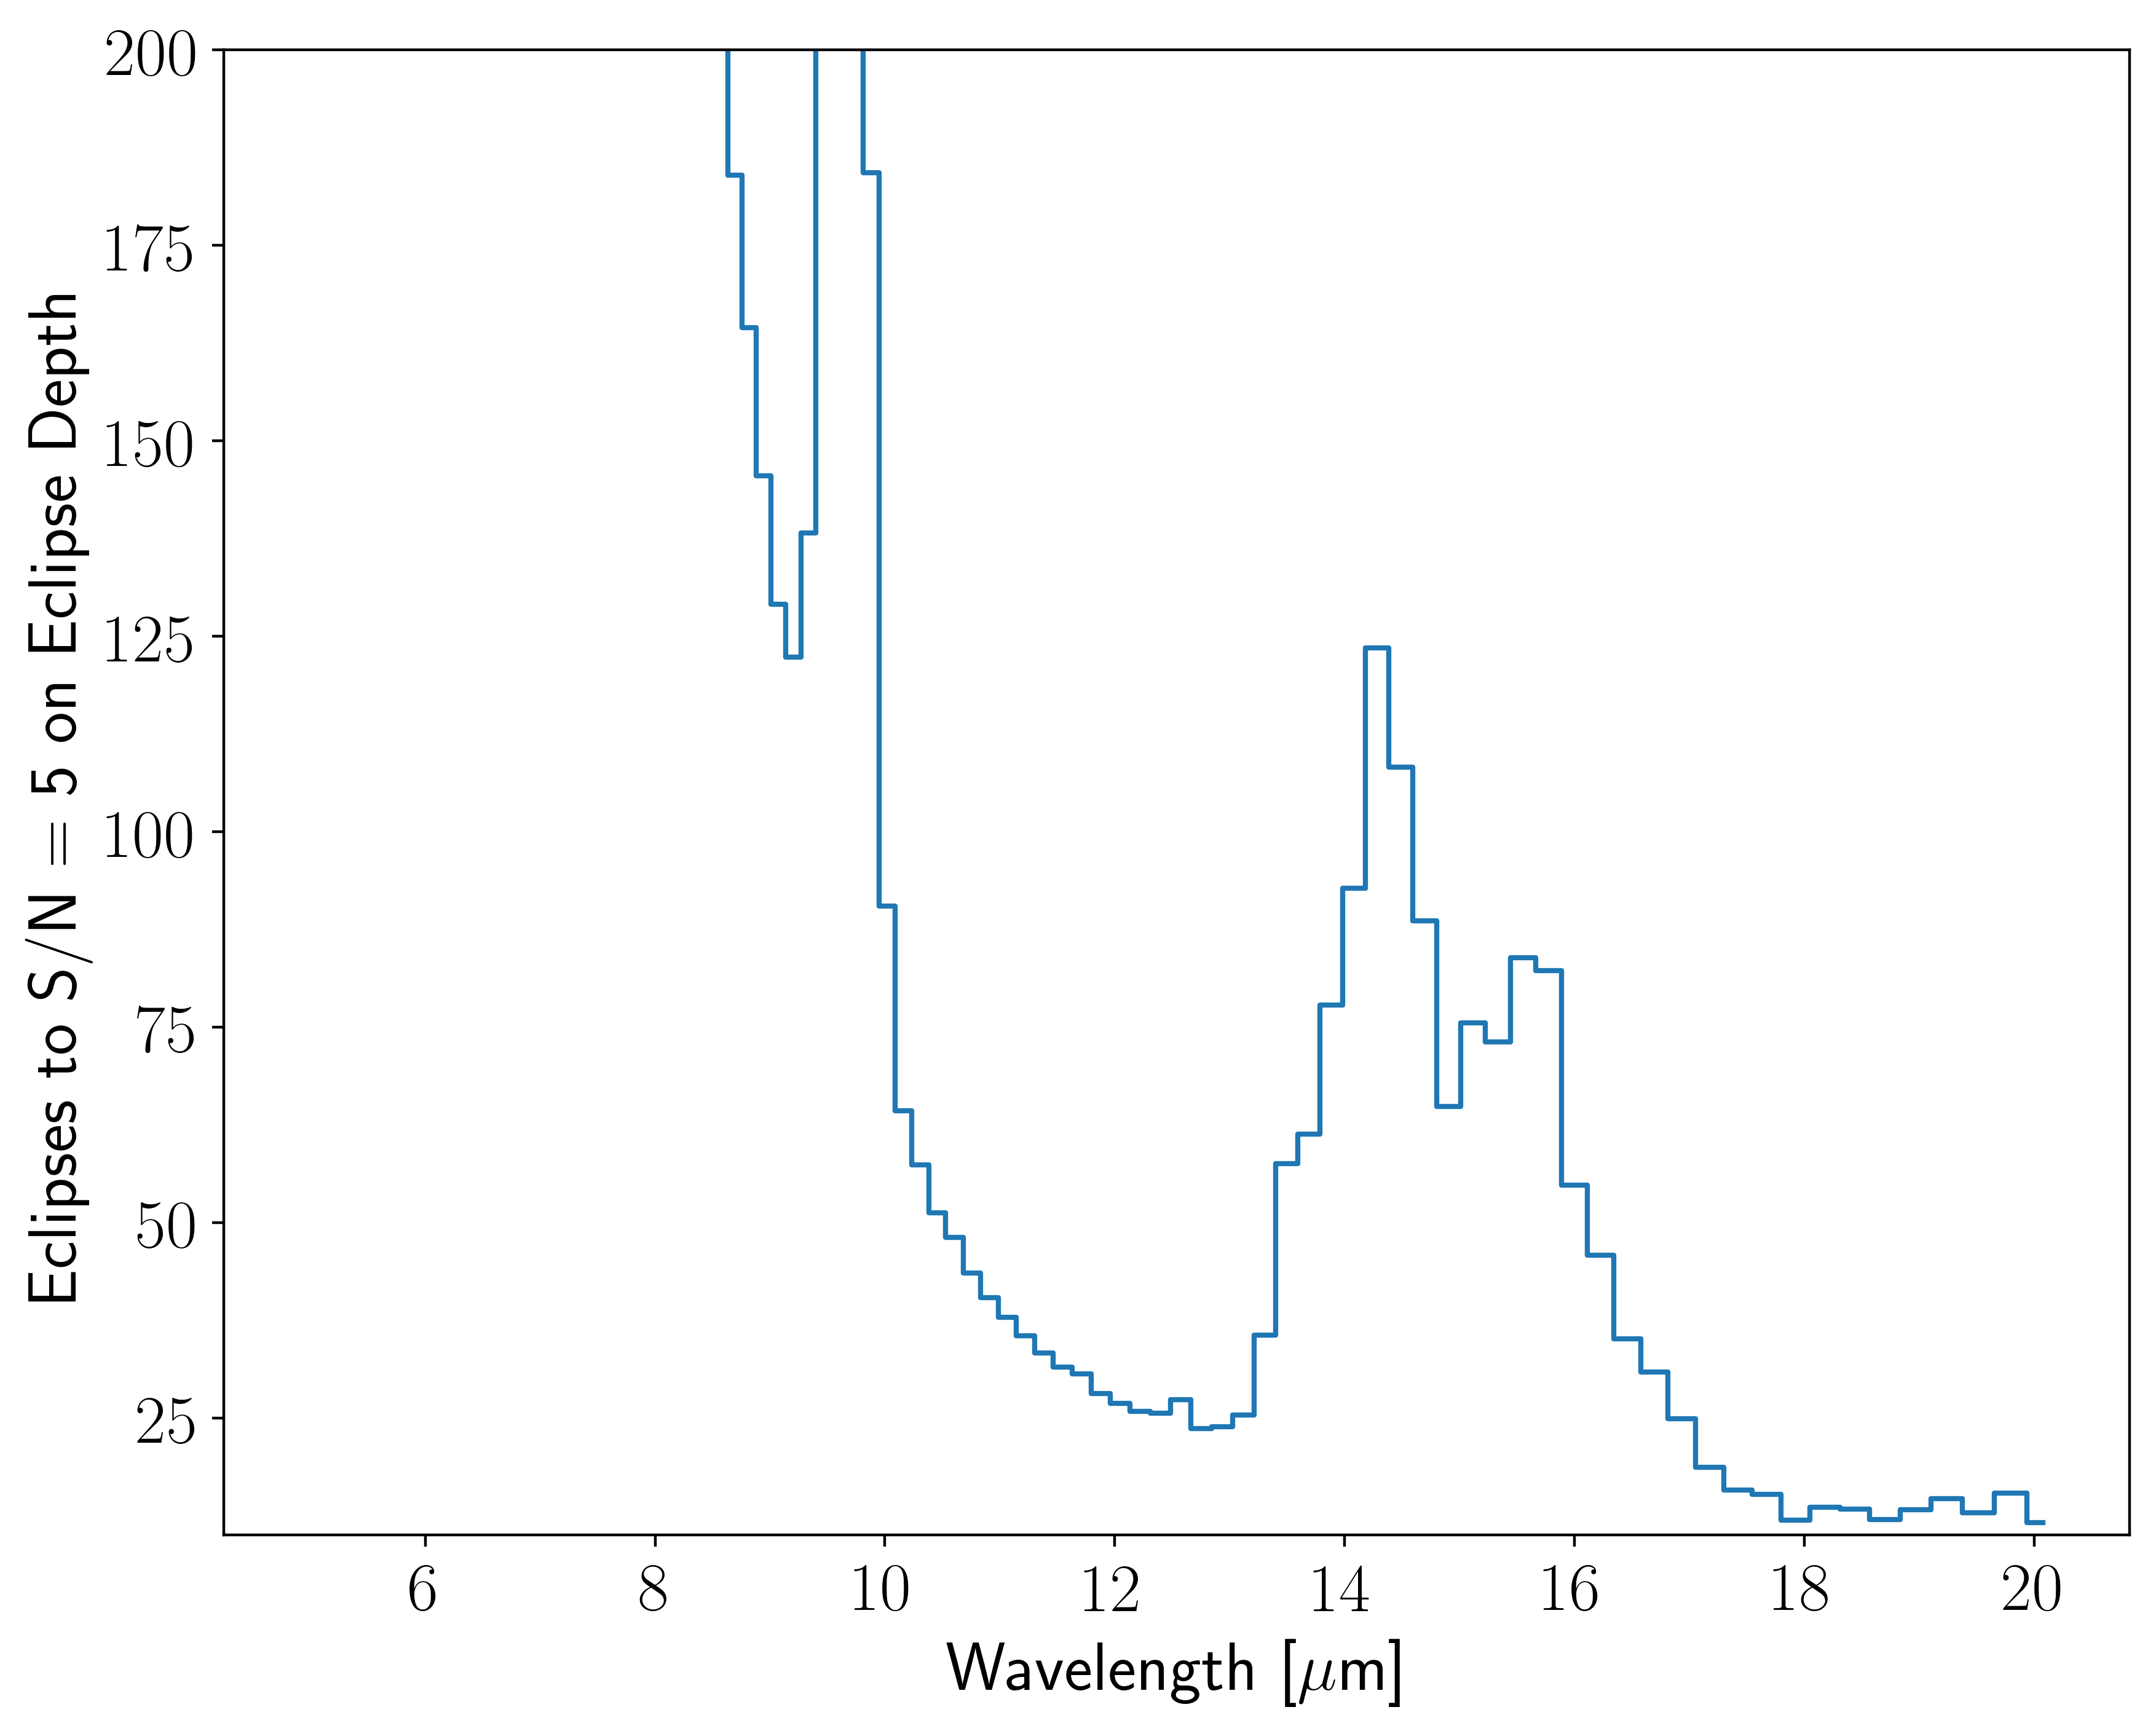

In [24]:
enm.recalc_wantsnr(wantsnr = 5.0)
fig, ax = enm.plot_ntran_to_wantsnr()
ax.set_yscale("linear")
ax.set_ylim(10,200);